In [1]:
%matplotlib inline


====================================================
How to convert 3D electrode positions to a 2D image.
====================================================

Sometimes we want to convert a 3D representation of electrodes into a 2D
image. For example, if we are using electrocorticography it is common to
create scatterplots on top of a brain, with each point representing an
electrode.

In this example, we'll show two ways of doing this in MNE-Python. First,
if we have the 3D locations of each electrode then we can use Mayavi to
take a snapshot of a view of the brain. If we do not have these 3D locations,
and only have a 2D image of the electrodes on the brain, we can use the
:class:`mne.viz.ClickableImage` class to choose our own electrode positions
on the image.



In [2]:
# Authors: Christopher Holdgraf <choldgraf@berkeley.edu>
#
# License: BSD (3-clause)
from scipy.io import loadmat
import numpy as np
from mayavi import mlab
from matplotlib import pyplot as plt
from os import path as op

import mne
from mne.viz import ClickableImage  # noqa
from mne.viz import plot_alignment, snapshot_brain_montage


print(__doc__)

subjects_dir = mne.datasets.sample.data_path() + '/subjects'
path_data = mne.datasets.misc.data_path() + '/ecog/sample_ecog.mat'

# We've already clicked and exported
layout_path = op.join(op.dirname(mne.__file__), 'data', 'image')
layout_name = 'custom_layout.lout'

Load data
---------

First we'll load a sample ECoG dataset which we'll use for generating
a 2D snapshot.



In [3]:
mat = loadmat(path_data)
ch_names = mat['ch_names'].tolist()
elec = mat['elec']
dig_ch_pos = dict(zip(ch_names, elec))
mon = mne.channels.DigMontage(dig_ch_pos=dig_ch_pos)
info = mne.create_info(ch_names, 1000., 'ecog', montage=mon)
print('Created %s channel positions' % len(ch_names))

Project 3D electrodes to a 2D snapshot
--------------------------------------

Because we have the 3D location of each electrode, we can use the
:func:`mne.viz.snapshot_brain_montage` function to return a 2D image along
with the electrode positions on that image. We use this in conjunction with
:func:`mne.viz.plot_alignment`, which visualizes electrode positions.



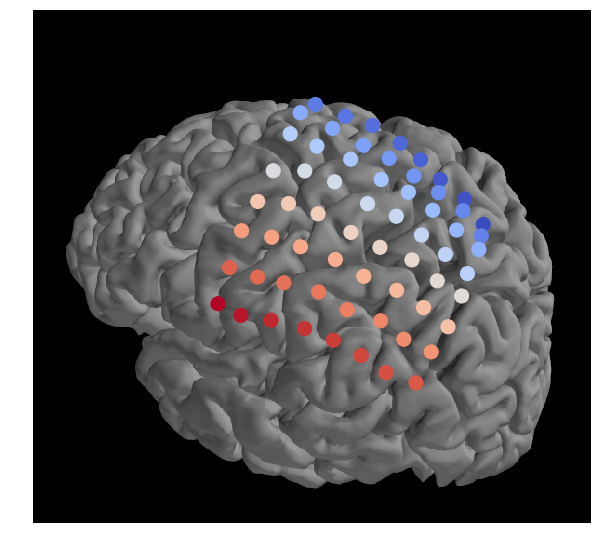

In [4]:
fig = plot_alignment(info, subject='sample', subjects_dir=subjects_dir,
                     surfaces=['pial'], meg=False)
mlab.view(200, 70)
xy, im = snapshot_brain_montage(fig, mon)

# Convert from a dictionary to array to plot
xy_pts = np.vstack(xy[ch] for ch in info['ch_names'])

# Define an arbitrary "activity" pattern for viz
activity = np.linspace(100, 200, xy_pts.shape[0])

# This allows us to use matplotlib to create arbitrary 2d scatterplots
fig2, ax = plt.subplots(figsize=(10, 10))
ax.imshow(im)
ax.scatter(*xy_pts.T, c=activity, s=200, cmap='coolwarm')
ax.set_axis_off()
# fig2.savefig('./brain.png', bbox_inches='tight')  # For ClickableImage

Manually creating 2D electrode positions
----------------------------------------

If we don't have the 3D electrode positions then we can still create a
2D representation of the electrodes. Assuming that you can see the electrodes
on the 2D image, we can use :class:`mne.viz.ClickableImage` to open the image
interactively. You can click points on the image and the x/y coordinate will
be stored.

We'll open an image file, then use ClickableImage to
return 2D locations of mouse clicks (or load a file already created).
Then, we'll return these xy positions as a layout for use with plotting topo
maps.



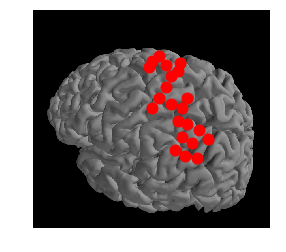

In [5]:
# This code opens the image so you can click on it. Commented out
# because we've stored the clicks as a layout file already.

# # The click coordinates are stored as a list of tuples
# im = plt.imread('./brain.png')
# click = ClickableImage(im)
# click.plot_clicks()

# # Generate a layout from our clicks and normalize by the image
# print('Generating and saving layout...')
# lt = click.to_layout()
# lt.save(op.join(layout_path, layout_name))  # To save if we want

# # We've already got the layout, load it
lt = mne.channels.read_layout(layout_name, path=layout_path, scale=False)
x = lt.pos[:, 0] * float(im.shape[1])
y = (1 - lt.pos[:, 1]) * float(im.shape[0])  # Flip the y-position
fig, ax = plt.subplots()
ax.imshow(im)
ax.scatter(x, y, s=120, color='r')
plt.autoscale(tight=True)
ax.set_axis_off()
plt.show()